In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
import math
import matplotlib.pyplot as plt
import numpy as np

Select which sub-example we want to visualize.

In [3]:
if True: outPath = 'example01-out-metal2d.1nn.100.h5'
else: outPath = 'example01-out-metal2d.2nn.1000.h5'

Load the relevant variables

In [4]:
with h5py.File(outPath,'r') as f:
    classAssignments = np.array(f['/classAssignments']) # An array of integers, assigning each neighborhood to a class
    classExemplars = np.array(f['/exemplars']) # Each class has an exemplar neighborhood; this is the array of exemplar neighborhood indices
    giipDistanceSquaredL2Minimized = np.array(f['/giipDistanceSquaredL2Minimized']) # Orientation-optimized GIIP distance squared
    minimalOrientationMatrices = np.array(f['/minimalOrientationMatrices']) # Pairwise optimal orientation matrices
    positions = np.array(f['/positions']) # Original positions of neighborhood atoms. Recall in "main.py" we randomized orientations.
    radii = np.array(f['/radii']) # rSkin and rCut
    weights = np.array(f['/weights']) # Weight matrices for all neighborhoods
nEnvironments = len(classAssignments)
rSkin = radii[0]
rCutoff = radii[1]

Prep some variables for future plotting.

In [5]:
thetaSampling = np.linspace(0,2*math.pi,num=360,endpoint=True)
xSkin = rSkin*np.cos(thetaSampling)
ySkin = rSkin*np.sin(thetaSampling)
xCutoff = rCutoff*np.cos(thetaSampling)
yCutoff = rCutoff*np.sin(thetaSampling)

Plot up to 1000 of the positions in their as-received state, so no orientation optimization has occurred here.
In the plot below, the dashed line represents rSkin and the solid line represents rCutoff; the black dot at (0,0) represents the central atom of each configuration. Dot sizes are scaled by the GIIP weights matrix, which goes from 1 inside of rSkin smoothly to 0 at rCutoff.

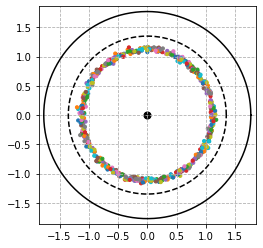

In [6]:
plt.figure()
plt.grid(linestyle='--')
for i in range(min(1000,nEnvironments)):
    plt.scatter(positions[i][:,0],positions[i][:,1], s=10*weights[i])
plt.scatter([0],[0],s=50,c='k')
plt.plot(xSkin,ySkin,c='k',linestyle='--')
plt.plot(xCutoff,yCutoff,c='k',linestyle='-')
plt.axis('square')
plt.xticks(ticks=np.linspace(-5,5,21))
plt.yticks(ticks=np.linspace(-5,5,21))
plt.xlim([-rCutoff*1.05,rCutoff*1.05])
plt.ylim([-rCutoff*1.05,rCutoff*1.05])
plt.show()

Plot the pairwise GIIP distances in a histogram. The peaks at a high GIIP distance represent defects. The orange histogram beneath the y=0 axis is roughly the log of the blue histogram above.

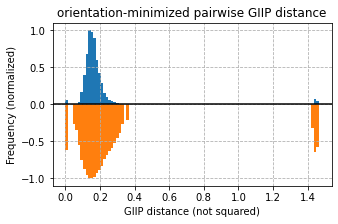

In [7]:
fig, axis = plt.subplots(1, 1, figsize=(5,3))
axis.set_title('orientation-minimized pairwise GIIP distance')
d = np.sqrt(np.abs(giipDistanceSquaredL2Minimized.reshape(-1)))
hist, bin_edges = np.histogram(d, bins=100)
logHist = np.log10(hist+1)
axis.bar(bin_edges[:-1] + (bin_edges[1]-bin_edges[0])/2,hist/np.max(hist),width=bin_edges[1]-bin_edges[0])
axis.bar(bin_edges[:-1] + (bin_edges[1]-bin_edges[0])/2,-logHist/np.max(logHist),width=bin_edges[1]-bin_edges[0])
axis.grid(True,linestyle='--')
axis.axhline(y=0,c='k')
axis.set_xlabel('GIIP distance (not squared)')
axis.set_ylabel('Frequency (normalized)')
fig.show()

Plot the classes in orientation-aligned coordinates. Colored dots represent neighborhoods in the classes. Black dots at (0,0) represent the central atoms of each configuration. Dot sizes are scaled by the GIIP weights matrix, which goes from 1 inside of rSkin smoothly to 0 at rCutoff.

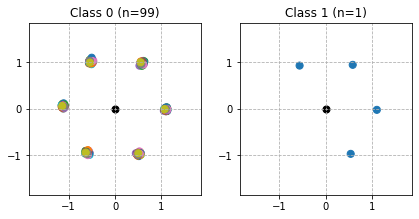

In [8]:
nClasses = len(classExemplars)
classes = [np.where(classAssignments==i)[0] for i in range(nClasses)]
if nClasses<=6: nH=nClasses
else: nH = 4
nV = math.ceil(nClasses / nH)
fig, axes = plt.subplots(nV, nH, figsize=(nH*3,nV*3))
if nV>1: axes = [axis for axesList in axes for axis in axesList]
for iClass, (cls,exemplar,axis) in enumerate(zip(classes,classExemplars,axes)):
    positions_cls = positions[cls]
    weights_cls = weights[cls]
    rotations = minimalOrientationMatrices[exemplar,cls]
    positions_cls_realigned = np.einsum('nij,nxj->nxi',rotations,positions_cls)
    
    #axis.scatter(positions[exemplar,:,0],positions[exemplar,:,1], s=300*np.ceil(weights[exemplar]), facecolors='none', edgecolors='k')
    
    for pos,wght in zip(positions_cls_realigned, weights_cls):
        axis.scatter(pos[:,0],pos[:,1], s=50*wght)
        
    axis.scatter([0],[0],s=50,c='k')
    axis.grid(True,linestyle='--')
    axis.axis('square')
    
    #axis.plot(xSkin,ySkin,c='k',linestyle='--')
    #axis.plot(xCutoff,yCutoff,c='k',linestyle='-')
    plt.axis('square')
    axis.set_xticks(ticks=np.linspace(-5,5,11))
    axis.set_yticks(ticks=np.linspace(-5,5,11))
    axis.set_xlim([-rCutoff*1.05,rCutoff*1.05])
    axis.set_ylim([-rCutoff*1.05,rCutoff*1.05])
    
    nClassPop = len(cls)
    axis.set_title(f'Class {iClass} (n={nClassPop})')

for i in range(len(classes), len(axes)): fig.delaxes(axes[i])
fig.tight_layout()
fig.show()

Plot the pairwise GIIP distances between classes.

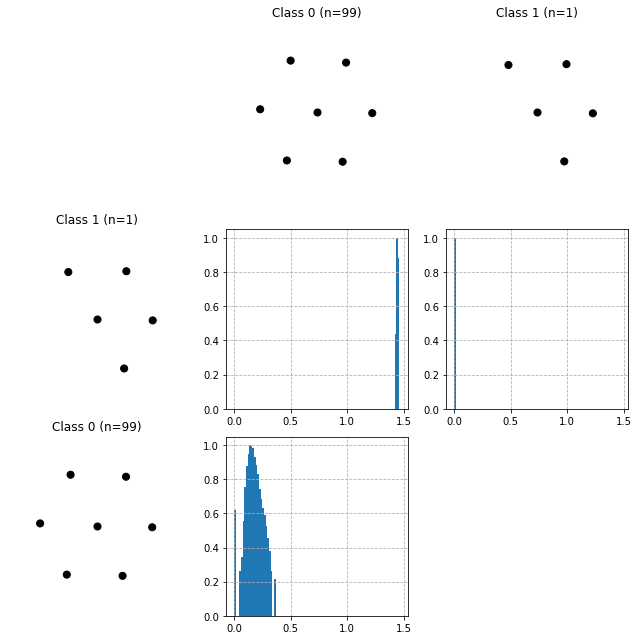

In [9]:
nClasses = len(classes)
fig, axes = plt.subplots(nClasses+1, nClasses+1, figsize=((nClasses+1)*3,(nClasses+1)*3))
#fig.delaxes(axes[0,0])
rowHeader = 0
colHeader = 0
def iRow(i): return nClasses-i
def iCol(i): return i+1

fig.delaxes(axes[rowHeader,colHeader])
for iClass in range(nClasses):
    iExemplar = classExemplars[iClass]
    positions_exemplar = positions[iExemplar]
    weights_exemplar = weights[iExemplar]
    nClassPop = len(classes[iClass])
    
    for axis in [axes[iRow(iClass),colHeader], axes[rowHeader,iCol(iClass)]]:
        axis.set_title(f'Class {iClass} (n={nClassPop})')
        axis.scatter(positions_exemplar[:,0],positions_exemplar[:,1], s=50*weights_exemplar, c='k')
        axis.scatter([0],[0],s=50,c='k')
        axis.set_axis_off()
        axis.axis('square')
        axis.set_xlim([-rCutoff,rCutoff])
        axis.set_ylim([-rCutoff,rCutoff])
        
    for jClass in range(nClasses):
        row = iRow(iClass)
        col = iCol(jClass)
        axis = axes[row,col]
        
        if iClass < jClass:
            fig.delaxes(axis)
            continue
        
        d = np.sqrt(np.abs(giipDistanceSquaredL2Minimized[classes[iClass],:][:,classes[jClass]].reshape(-1)))
        hist, bins = np.histogram(d, bins=bin_edges)
        logHist = np.log10(hist+1)
        #axis.bar(bin_edges[:-1] + (bin_edges[1]-bin_edges[0])/2,hist/np.max(hist),width=bin_edges[1]-bin_edges[0])
        axis.bar(bin_edges[:-1] + (bin_edges[1]-bin_edges[0])/2,logHist/np.max(logHist),width=bin_edges[1]-bin_edges[0])
        axis.grid(True,linestyle='--')
        #axis.axhline(y=0,c='k')
        
fig.tight_layout()

Save the current notebook to an html document for static viewing

In [10]:
outputString = outPath.replace('h5','html').replace('-out-','-visualize-')

In [12]:
! jupyter nbconvert visualize.ipynb --to html --output $outputString

[NbConvertApp] Converting notebook visualize.ipynb to html
[NbConvertApp] Writing 726470 bytes to example01-visualize-metal2d.1nn.100.html
